# Simulating the Physics of a Curveball
Arwen Sadler and Leila Merzenich

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

For this project, we wanted to make a simulation modeling the behavior of a curveball.

According to [the MLB website](https://www.mlb.com/news/statcast-spin-rate-compared-to-velocity/c-160896926), the average speed of a curveball in the 2015 season was 78.2 mph, or about 34.96 m/s, and that the average rpm was 2,308.

We estimated the height at which the ball leaves the pitcher's hand by watching slow-motion videos of curveball pitches and using the pitcher's height as a reference.

We found the angle of throw by sweeping angles between 0 and 5 degrees through a function that returned the final height of the ball when it reaches home plate, knowing that we wanted the height to be in the center of the strike zone (about 0.93 m).

In [2]:
params = Params(x = 0, 
                y = 1.7,
                z = 0, # A line connecting the mound to home plate
                g = 9.8, #gravity
                mass = 145e-3,
                diameter = 73e-3,
                rho = 1.2,
                C_d = 0.33,
                angle = 10, #angle of throw b/w x and y axes--2.17 w/ no rotation
                angle_rot = 35, #angle of rotation b/w y and z axes
                velocity = 34.96,
                rps = 2308 / 60,
                t_end = 10)

,values
x,0.000000
y,1.700000
z,0.000000
g,9.800000
mass,0.145000
diameter,0.073000
rho,1.200000
C_d,0.330000
angle,10.000000
angle_rot,35.000000


In [3]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to radians
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # compute the z component of velocity--presumably the pitcher throws the ball straight
    vz = 0 
    
    # make the initial state
    init = State(x=x, y=y, z=z, vx=vx, vy=vy, vz=vz)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [4]:
system = make_system(params)

,values
x,0
y,1.7
z,0
g,9.8
mass,0.145
diameter,0.073
rho,1.2
C_d,0.33
angle,10
angle_rot,35


In [5]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = rho * v.mag**2 * C_d * area / 2
    direction = -v.hat()
    f_drag = direction * mag
    return f_drag

In [6]:
v_test = Vector(10, 10)
drag_force(v_test, system)

<Quantity([-0.11719681 -0.11719681], 'dimensionless')>

Magnus Force also effects the path of the ball. According to NASA, the lift on a sphere caused by Magnus Force is:

L = 16/3 (pi^2 * r^3 * s * rho * V)

Where s is the angular velocity of the ball, r is the radius of the ball, rho is the density of the air, and V is the velocity of the air in comparison to the velocity of the ball.

In [7]:
def mag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    
    # convert angle_rot to radians
    theta_rot = np.deg2rad(angle_rot)
    
    # compute magnus force direction
    lz, ly = pol2cart(theta_rot, 1)
    
    s = Vector(0, ly, lz)
    
    mag = 16/3 * (np.pi**2 * (diameter/2)**3 * rps * rho * v.mag) #Assuming air velocity is 0
    direction = -s.hat()#the direction it's rotating, a unit vector in the system
    L = direction * mag
    
    return L

In [8]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, z, vx, vy, vz = state
    unpack(system)

    v = Vector(vx, vy, vz)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g, 0)
    a_mag = mag_force(v, system) / mass
    
    a = a_grav + a_drag + a_mag
    
    return vx, vy, vz, a.x, a.y, a.z

In [9]:
slope_func(system.init, 0, system)

(34.42887904530679,
 6.070740291235884,
 0.0,
 <Quantity(-6.879028306460739, 'dimensionless')>,
 <Quantity(-27.352414168499262, 'dimensionless')>,
 <Quantity(-23.33516134200681, 'dimensionless')>)

In [10]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, z, vx, vy, vz = state
    return x - 18.44

In [11]:
event_func(system.init, 0, system)

-18.44

In [12]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.1)
details

,values
sol,None
t_events,[[0.5653656759688493]]
nfev,62
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [13]:
#How long the ball flew for
flight_time = get_last_label(results)

0.5653656759688493

In [14]:
#How far the ball flew
x_dist = get_last_value(results.x)

18.44

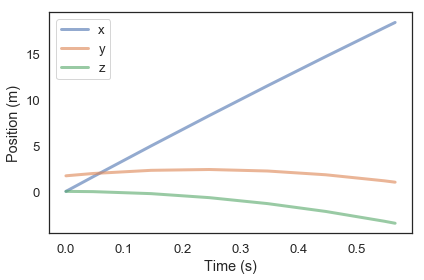

In [15]:
plot(results.x, label='x')
plot(results.y, label='y')
plot(results.z, label='z')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

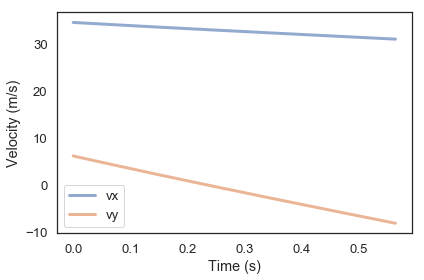

In [16]:
plot(results.vx, label='vx')
plot(results.vy, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

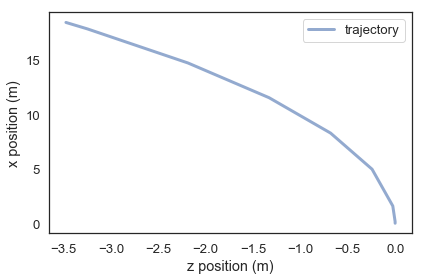

In [17]:
def plot_trajectory(results):
    plot(results.z, results.x, label='trajectory')

    decorate(xlabel='z position (m)',
             ylabel='x position (m)')
    
plot_trajectory(results)

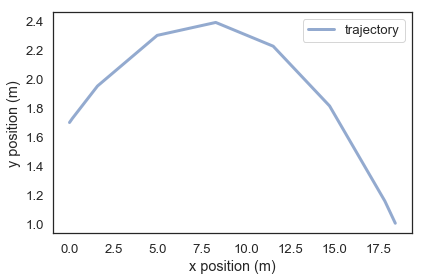

In [18]:
def plot_trajectory2(results):
    plot(results.x, results.y, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory2(results)